In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib.pyplot import subplots, style, rc
from tqdm import tqdm
from venn import venn, pseudovenn
from collections import defaultdict
from itertools import count, islice
from functools import lru_cache

In [465]:
from edgecaselib.repeatfinder import lowest_alpha_inversion as lai, custom_alpha_inversion as cai
from edgecaselib.util import revcomp
from regex import finditer, IGNORECASE
from matplotlib.patches import Rectangle
from scipy.stats import mannwhitneyu, wilcoxon
from itertools import product
%matplotlib inline

In [276]:
from pysam import AlignmentFile
from glob import glob

READ_NAMES = {"p": defaultdict(set), "q": defaultdict(set)}
for filename in tqdm(glob("ONT/AshkenazimTrio/HG002/guppy-V*tailpuller.bam")):
    version = re.search(r'\d.\d.\d', filename).group()
    with AlignmentFile(filename) as bam:
        for entry in bam:
            if entry.flag & 3844 == 0:
                if entry.flag & 0x4000 == 0x4000:
                    arm = "q" if (entry.flag & 0x8000 == 0x8000) else "p"
                    READ_NAMES[arm][version].add(entry.qname)

COMMON_Q_NAMES = set.intersection(*READ_NAMES["q"].values())
VERSIONS = sorted(READ_NAMES["q"].keys())

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


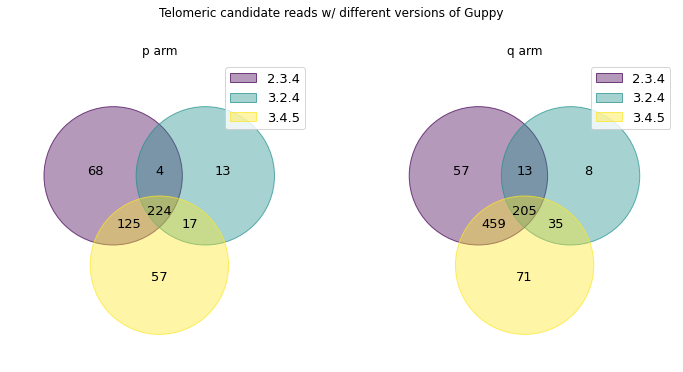

In [177]:
figure, axs = subplots(figsize=(12, 6), ncols=2)
for arm, ax in zip("pq", axs):
    venn(READ_NAMES[arm], ax=ax)
    ax.set(title=f"{arm} arm")

_ = figure.suptitle("Telomeric candidate reads w/ different versions of Guppy")

In [256]:
KMER_COUNTS = pd.concat(
    objs=[
        pd.read_csv(filename, sep="\t", names=["kmer", re.search(r'\d.\d.\d', filename).group()], index_col=0)
        for filename in tqdm(sorted(glob("ONT/AshkenazimTrio/HG002/guppy-V*tailchopper.tsv")))
    ],
    axis=1, sort=False,
)

KMER_FRAQS = KMER_COUNTS / KMER_COUNTS.sum()
KMER_FRAQS["identity"] = KMER_FRAQS.index.map(lambda m: max(cai(revcomp(cai(m))), cai(m)))
KMER_FRAQS = KMER_FRAQS.groupby("identity").sum()
KMER_FRAQS.index.name = "kmer"

100%|██████████| 3/3 [00:00<00:00, 373.42it/s]


In [483]:
TARGET_KMERS = set.union(*(
    set(KMER_FRAQS[version].sort_values(ascending=False)[:4].index)
    for version in KMER_COUNTS.columns
))

TARGET_FRAQS = KMER_FRAQS.loc[TARGET_KMERS]
TARGET_KMERS_ORDERED = list(TARGET_FRAQS.index)
TARGET_FRAQS

,2.3.4,3.2.4,3.4.5
kmer,,,
TTAGGG,0.092481,0.015490,0.092932
GAAAAA,0.009149,0.010395,0.009628
GAAGAA,0.004532,0.007884,0.006332
TTGGGG,0.013005,0.004900,0.011142
TTTTTG,0.007915,0.008395,0.008087


In [484]:
id2m = defaultdict(set)
for m in KMER_COUNTS.index:
    id2m[max(cai(revcomp(cai(m))), cai(m))].add(m)

In [485]:
per_read_fraqs = {
    m: pd.DataFrame(columns=READ_NAMES["q"].keys(), dtype=float)
    for m in TARGET_KMERS
}

for filename in tqdm(glob("ONT/AshkenazimTrio/HG002/guppy-V*tailchopper.bam")):
    version = re.search(r'\d.\d.\d', filename).group()
    with AlignmentFile(filename) as bam:
        for entry in bam:
            if entry.flag & 3844 == 0:
                if entry.flag & 0xC000 == 0xC000:
                    for m in TARGET_KMERS:
                        m_count = sum(
                            1 for _ in finditer(r'|'.join(id2m[m]), entry.seq, overlapped=True)
                        )
                        per_read_fraqs[m].loc[entry.qname, version] = m_count / len(entry.seq)

100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


In [486]:
converted_list = []

for m in TARGET_KMERS:
    narrow = per_read_fraqs[m].melt(var_name="version", value_name="hits per base").dropna()
    narrow["kmer"] = m
    converted_list.append(narrow)

fraq_dists = pd.concat(converted_list, sort=False)

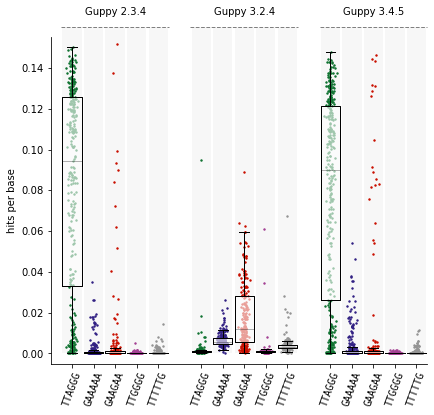

In [487]:
nv, nk = len(VERSIONS), len(TARGET_KMERS)
#dispatcher = fraq_dists[["version", "kmer"]].drop_duplicates().sort_values(by="version").reset_index(drop=True)

figure, ax = subplots(figsize=(nv*(nk+4)/4, 6))
x = -1
ticks, titles, ticklabels = [], [], []

KMER_COLORS = {
    "TTAGGG": "#117733",
    "GAAAAA": "#332288",
    "GAAGAA": "#D01000",
    "TTGGGG": "#AA4499",
    "TGGGCC": "orange",
    "TGAGGG": "#DDCC77",
    "TTTTAA": "purple",
    "TTTTTG": "#999999",
}

for i, (version, kmer) in enumerate(product(VERSIONS, TARGET_KMERS_ORDERED)):
    if i % nk == 0:
        x += 2
    else:
        x += 1
    titles.append(version)
    ticks.append(x)
    ticklabels.append(kmer)
    data = fraq_dists.loc[(fraq_dists["version"]==version) & (fraq_dists["kmer"]==kmer), "hits per base"]
    ax.add_patch(Rectangle(
        (x-.45, 0), .9, .16, facecolor="#00000008", clip_on=False,
    ))
    ax.scatter(x=np.random.normal(x, .1, len(data)), y=data, color=KMER_COLORS[kmer], s=2)
    parts = ax.boxplot(
        data, positions=[x], widths=[.9], showfliers=False,
        medianprops=dict(color="black", alpha=.3),
    )
    xd, yd = parts["boxes"][0].get_xdata(), parts["boxes"][0].get_ydata()
    ax.add_patch(Rectangle(
        (xd.min(), yd.min()), xd.max()-xd.min(), yd.max()-yd.min(),
        facecolor="#FFFFFF99",
    ))

ax.set(xticks=ticks, xticklabels=ticklabels, ylim=(-.005, .155))
for tick in ax.get_xticklabels():
    tick.set(rotation=70, fontname="Monospace")

for spine in "top", "right":
    ax.spines[spine].set(visible=False)

for version, x in zip(VERSIONS, [(nk+1)/2, (nk+1)/2+nk+1, (nk+1)/2+(nk+1)*2]):
    ax.text(x=x, y=.165, s=f"Guppy {version}", ha="center", va="bottom")
    ax.plot([x-nk/2, x+nk/2], [.16, .16], color="gray", lw=1, ls="--", clip_on=False)

ax.set(xlim=(0, ax.get_xlim()[1]), ylabel="hits per base")
figure.savefig("Figure SY, ONT.pdf", bbox_inches="tight")

In [429]:
_, ttaggg_p1 = mannwhitneyu(
    fraq_dists.query("(version=='3.2.4') & (kmer=='TTAGGG')")["hits per base"],
    fraq_dists.query("(version=='2.3.4') & (kmer=='TTAGGG')")["hits per base"],
    alternative="less",
)
ttaggg_p1 # TTAGGG in 3.2.4 is less frequent than in 2.3.4

5.669624079052662e-66

In [430]:
_, ttaggg_p2 = mannwhitneyu(
    fraq_dists.query("(version=='3.2.4') & (kmer=='TTAGGG')")["hits per base"],
    fraq_dists.query("(version=='3.4.5') & (kmer=='TTAGGG')")["hits per base"],
    alternative="less",
)
ttaggg_p2 # TTAGGG in 3.2.4 is less frequent than in 3.4.5

2.4171992340962484e-64

In [499]:
_, gaagaa_p1 = mannwhitneyu(
    fraq_dists.query("(version=='2.3.4') & (kmer=='GAAGAA')")["hits per base"],
    fraq_dists.query("(version=='3.2.4') & (kmer=='GAAGAA')")["hits per base"],
    alternative="less",
)

gaagaa_p1 # GAAGAA in 3.2.4 is more frequent than in 2.3.4

4.1888904848499314e-50

In [501]:
_, gaagaa_p2 = mannwhitneyu(
    fraq_dists.query("(version=='3.4.5') & (kmer=='GAAGAA')")["hits per base"],
    fraq_dists.query("(version=='3.2.4') & (kmer=='GAAGAA')")["hits per base"],
    alternative="less",
)

gaagaa_p2 # GAAGAA in 3.4.5 is more frequent than in 2.3.4

1.345919150777346e-43

In [504]:
from statsmodels.stats.multitest import multipletests
multipletests([ttaggg_p1, ttaggg_p2, gaagaa_p1, gaagaa_p2], method="bonferroni")[1]

array([2.26784963e-65, 9.66879694e-64, 1.67555619e-49, 5.38367660e-43])

Jellyfish three versions for 6-mers, select five top 6-mers.

Not only did TTAGGG occur only about once every 10 bases in the "better" guppies, but:
* TTAGGG was significantly less frequent in Guppy 3.2.4 than in two other versions (p=2.3e-64 and p=1e-63, respectively)
* GAAGAA was significantly more frequent (p=1.7e-49, p=5.4e-43)

While it looks like 3.2.4 is just the odd one out, the fact that the output of the model changes so drastically and seemingly arbitrarily between different versions of the basecaller indicates that it is too early to trust these outputs for telomere analyses.